In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_json(r'/kaggle/input/preprocessed/preprocess_data.json')
df

,name,asin,brand,color,size,price,department,origin,rating,star,...,Not Bleach,Tumble Dry,Pull on,Tie,Zipper,Button,No closure,Elastic,Lace Up,Drawstring
0,3 Pack Mens Athletic Sweatpants with Zipper Po...,B0CT3G46LT,295,5,0,44.99,2,0,909,4.5,...,0,0,0,0,1,0,0,0,0,0
1,3 Pack Mens Athletic Sweatpants with Zipper Po...,B0CYGX1VRB,295,0,2,45.99,2,0,909,4.5,...,0,0,0,0,1,0,0,0,0,0
2,3 Pack Mens Athletic Sweatpants with Zipper Po...,B0CWLJN23H,295,0,3,44.99,2,0,909,4.5,...,0,0,0,0,1,0,0,0,0,0
3,3 Pack Mens Athletic Sweatpants with Zipper Po...,B0CT3JXKKT,295,1,1,44.99,2,0,909,4.5,...,0,0,0,0,1,0,0,0,0,0
4,2Pack Men's Rash Guard UPF 50+ Sun Protection ...,B0CQC72M2D,198,0,4,16.99,2,0,35,4.1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19763,Women's Full Slips Adjustable Spaghetti Strap ...,B0D1TH4KMX,158,10,3,27.99,1,0,15,4.6,...,0,0,0,0,0,0,1,0,0,0
19764,Women's Full Slips Adjustable Spaghetti Strap ...,B0D8SXP3WB,158,7,2,27.99,1,0,15,4.6,...,0,0,0,0,0,0,1,0,0,0
19765,Women's Full Slips Adjustable Spaghetti Strap ...,B0D8SYVMC4,158,1,1,27.99,1,0,15,4.6,...,0,0,0,0,0,0,1,0,0,0
19766,Women's Full Slips Adjustable Spaghetti Strap ...,B0CTYL3FB9,158,5,2,27.99,1,0,15,4.6,...,0,0,0,0,0,0,1,0,0,0


In [24]:
df.drop(['name', 'asin', 'url'], axis=1, inplace=True)

# df['log_price'] = np.log(df['price'] + 1)
# df.drop(['price'], axis=1, inplace=True)

df['brand'] = df['brand'].astype('category')
df['brand_encoded'] = df['brand'].cat.codes
df.drop(['brand'], axis=1, inplace=True)

df['color'].isna().sum()

df['color'] = df['color'].astype('category')
df['color_encoded'] = df['color'].cat.codes
df.drop(['color'], axis=1, inplace=True)

df['department'] = df['department'].astype('category')
df['department_encoded'] = df['department'].cat.codes
df.drop(['department'], axis=1, inplace=True)

df['origin'] = df['origin'].astype('category')
df['origin_encoded'] = df['origin'].cat.codes
df.drop(['origin'], axis=1, inplace=True)

df.department_encoded.value_counts()

df= df.fillna(df.mean())

# print(df.isnull().sum())

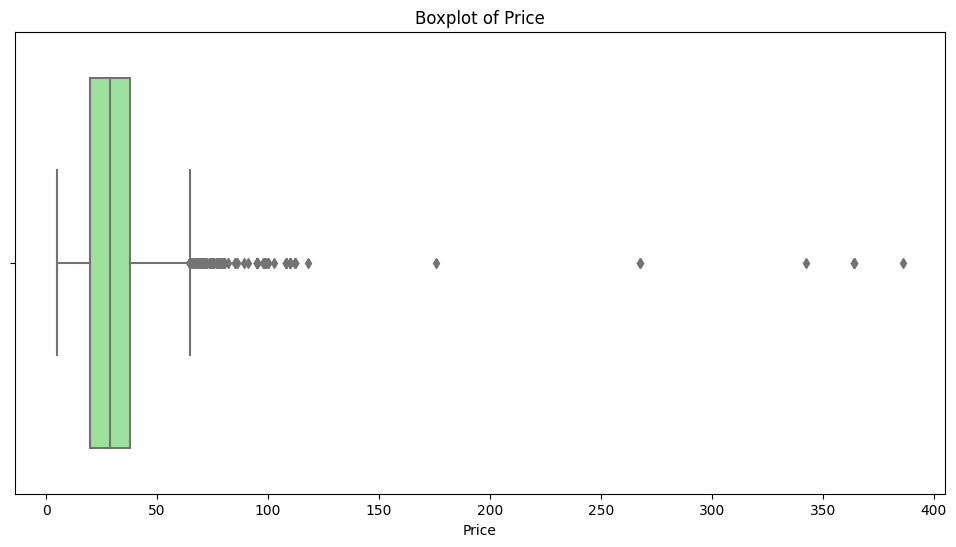

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'], color='lightgreen')
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

In [26]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


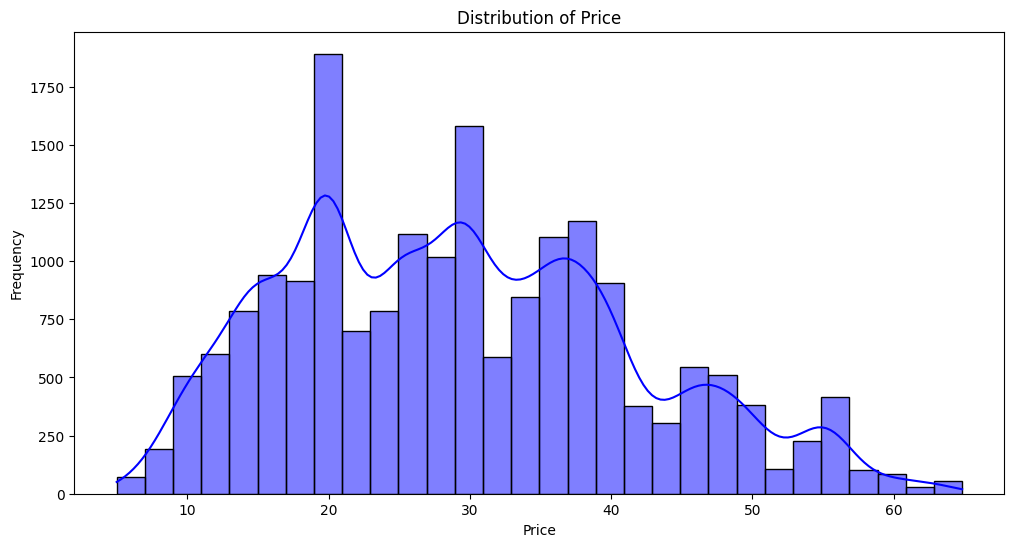

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
X = df.drop("price", axis=1)
y = df["price"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
df.department_encoded.value_counts()

department_encoded
1    12516
2     6197
0      144
Name: count, dtype: int64

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1).to(device)

In [34]:
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [35]:
n_epochs = 1000
batch_size = 512
learning_rate = 0.0001

In [36]:
import wandb

# Khởi tạo WandB
wandb.init(
    project="price_prediction",
    config={
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "n_epochs": n_epochs,
        "model": "FullyConnectedNN",
    }
)


In [37]:
input_dim = X_train_tensor.shape[1]
print(input_dim)
model = FCNN(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

31


In [38]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True
)

In [39]:
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Tính R^2
    y_true = y_batch.cpu().detach().numpy()  # Chuyển sang numpy array nếu cần
    y_pred = y_pred.cpu().detach().numpy()  # Chuyển sang numpy array nếu cần
    r2 = r2_score(y_true, y_pred)
    
    if epoch >= 200:
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss / len(train_loader),
            "r2_score": r2
        })
        
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / len(train_loader)}, R^2 Score: {r2}")

wandb.finish()

Epoch 201/1000, Loss: 88.35302759806315, R^2 Score: 0.44937188349309454
Epoch 202/1000, Loss: 86.88837610880533, R^2 Score: 0.40051159986190576
Epoch 203/1000, Loss: 84.16531168619791, R^2 Score: 0.4067134230192262
Epoch 204/1000, Loss: 85.019775390625, R^2 Score: 0.35185729500262375
Epoch 205/1000, Loss: 85.4797742207845, R^2 Score: 0.5149233903233954
Epoch 206/1000, Loss: 85.56196416219076, R^2 Score: 0.452979411831689
Epoch 207/1000, Loss: 85.17708791097006, R^2 Score: 0.4746516399711759
Epoch 208/1000, Loss: 82.84924926757813, R^2 Score: 0.5090524116023859
Epoch 209/1000, Loss: 82.61233469645182, R^2 Score: 0.4658636444941052
Epoch 210/1000, Loss: 83.47138595581055, R^2 Score: 0.42438610585192016
Epoch 211/1000, Loss: 85.13370768229167, R^2 Score: 0.3252861200286359
Epoch 212/1000, Loss: 82.5451644897461, R^2 Score: 0.49447326983904993
Epoch 213/1000, Loss: 82.195804977417, R^2 Score: 0.5386016203476396
Epoch 214/1000, Loss: 80.99292475382487, R^2 Score: 0.4382533934392092
Epoch 21

epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
loss,███▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁
r2_score,▁▁▃▃▁▄▆▆▅▄▅▇▇▅▆▅▇▆▇▇▆▆▆▆▅▇▇█▆▇█▇▇▇▇█▇▆██
epoch,1000
loss,39.64216
r2_score,0.72133


In [40]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

y_pred = y_pred.flatten()  # Flatten output để tính metrics

# Tính MAE, RMSE và R²
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


MAE: 3.8915230472823596
RMSE: 5.680131889382351
R² Score: 0.7825179448560952


In [41]:
torch.save(model.state_dict(), "fcnn_model.pth")

In [42]:
num_sample = 20
sample_rows = df.sample(num_sample)

# Tách đặc trưng và nhãn từ mẫu ngẫu nhiên
X_samples = sample_rows.drop("price", axis=1)
y_true = sample_rows['price'].values

# Chuyển đổi đặc trưng thành tensor và đưa vào thiết bị
X_sample_tensor = torch.tensor(X_samples.values, dtype=torch.float32).to(device)

# Đặt mô hình ở chế độ evaluate (để tắt dropout và BN)
model.eval()

# Thực hiện dự đoán cho mỗi mẫu
with torch.no_grad():
    y_pred_log = model(X_sample_tensor).cpu().numpy().flatten()

# Kết hợp giá trị thực và dự đoán vào một danh sách
results = []
for i in range(num_sample):
    true_price = y_true[i]
    pred_price = y_pred_log[i]
    results.append((true_price, pred_price, pred_price - true_price))

# Sắp xếp kết quả dựa trên giá trị `real price`
results_sorted = sorted(results, key=lambda x: x[0])

# In kết quả đã sắp xếp
for i, (true_price, pred_price, diff) in enumerate(results_sorted):
    print(f"Sample {i} - Real price: {true_price:.2f}, Predicted price: {pred_price:.2f}, Difference: {diff:.2f}")

Sample 0 - Real price: 7.99, Predicted price: 18.69, Difference: 10.70
Sample 1 - Real price: 11.50, Predicted price: 28.24, Difference: 16.74
Sample 2 - Real price: 15.99, Predicted price: 18.29, Difference: 2.30
Sample 3 - Real price: 19.99, Predicted price: 19.33, Difference: -0.66
Sample 4 - Real price: 19.99, Predicted price: 19.24, Difference: -0.75
Sample 5 - Real price: 26.04, Predicted price: 35.78, Difference: 9.74
Sample 6 - Real price: 28.99, Predicted price: 27.15, Difference: -1.84
Sample 7 - Real price: 29.99, Predicted price: 22.41, Difference: -7.58
Sample 8 - Real price: 29.99, Predicted price: 25.09, Difference: -4.90
Sample 9 - Real price: 29.99, Predicted price: 30.03, Difference: 0.04
Sample 10 - Real price: 29.99, Predicted price: 30.68, Difference: 0.69
Sample 11 - Real price: 30.99, Predicted price: 32.84, Difference: 1.85
Sample 12 - Real price: 31.99, Predicted price: 29.14, Difference: -2.85
Sample 13 - Real price: 32.99, Predicted price: 29.86, Difference: 